In [1]:
import tensorflow as tf
import CapsLayer as cp
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib notebook

mnist = input_data.read_data_sets("/tmp/data/")



Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
tf.reset_default_graph()

input_dim = [28,28]

X = tf.placeholder(shape=[None, input_dim[0],input_dim[1], 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")


In [3]:
num_classes = 10
conv1 = tf.layers.conv2d(X, name="conv1", filters = 128, 
                         kernel_size = 9,strides = 1,padding = "valid", activation = tf.nn.relu)
#primary caps
conv2 = cp.conv_to_caps(conv1,num_maps=16,caps_dims=4,kernel_size = 4,strides = 2
                        ,name="conv2", activation = tf.nn.relu)


In [4]:
init_sigma = 0.1

caps2_output = cp.capsule(conv2,num_caps=num_classes,caps_dims=4,
                           batch_size=tf.shape(X)[0],init_sigma = init_sigma,name = "caps2")
output = caps2_output


In [5]:
y_proba = cp.safe_norm(output, axis=2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=1, name="y_proba")
#y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y_pred = y_proba_argmax


In [6]:
loss = cp.margin_loss(output,num_classes,y)
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_op = optimizer.minimize(loss, name="training_op")


init = tf.global_variables_initializer()
saver = tf.train.Saver()

Tensor("absent_error:0", shape=(?, 10), dtype=float32)


In [7]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_op = optimizer.minimize(loss, name="training_op")


init = tf.global_variables_initializer()
saver = tf.train.Saver()

Starting training MNIST


<IPython.core.display.Javascript object>


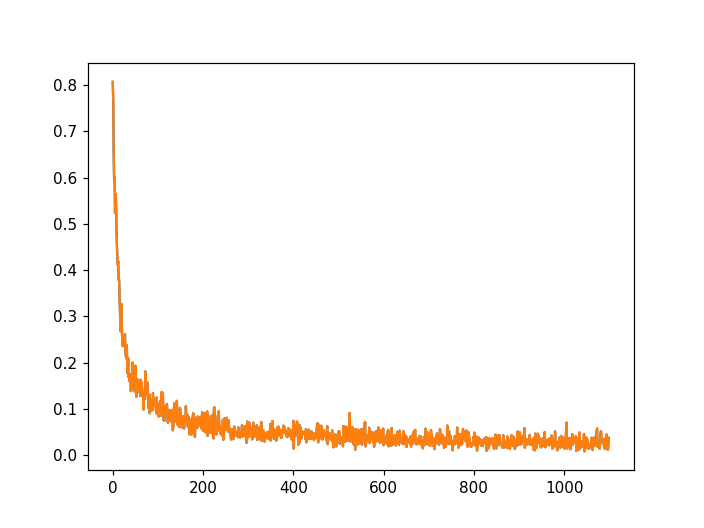

Epoch: 1  Val accuracy: 98.6467%  Loss: 0.026308 (improved)6 2 3 7 3]  real : [6 2 3 7 3]


In [8]:
MNIST = True
print("Starting training MNIST")
n_epochs = 1
batch_size = 50


n_iterations_per_epoch = mnist.train.num_examples // batch_size

restore_checkpoint = True

n_iterations_validation = 300#mnist.train.num_examples // batch_size

best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    
    save=False
    if save:
        if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
            saver.restore(sess, checkpoint_path)
        else:
            init.run()
    else:
        init.run()
    
    predicted = ""
    for epoch in range(n_epochs):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        #fig.show()
        fig.canvas.draw()
        loss_data = np.zeros([n_iterations_per_epoch])
        for iteration in range(1, n_iterations_per_epoch + 1):
            
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape([-1, 28, 28, 1])
            
            _, loss_train,pred,real,proba = sess.run(
                [training_op, loss,y_pred,y,y_proba],
                feed_dict={X: X_batch,
                           y: y_batch})
                           #mask_with_labels: True})
            if(iteration % 50 == 0):
                predicted = "  predicted : {}  real : {}".format(pred[0:5],real[0:5])#proba[0][0])
            print(("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}"+predicted).format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            loss_data[iteration-1] = loss_train
            
            ax.clear()
            ax.plot(loss_data)
            fig.canvas.draw()
            
        plt.plot(loss_data)
        plt.ioff()
        plt.show()
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape([-1, 28, 28, 1])
                
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, input_dim[0], input_dim[1], 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val and save:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val